# Curso: Ciência de Dados e Analytics (PUC Rio)
## Sprint: Machine Learning & Analytics
#### Professores:
> Profs. Drs. Augusto Baffa, Luiz Schirmer e Jonatas Grosman 

#### Aluno:
> Wellington Bastos, M.Sc.

## Abrangência:

###  SPRINT II - MVP - letra b - modelo utilizando redes neurais com Processamento de Linguagem  Natural (PLN)

**Problema**: Como classificar e prever KPI de falhas técnicas na rede móvel a partir de uma descrição textual?

**Motivação**: As redes de Telecomunicações Móveis são sistemas complexos de engenharia cujo requisito principal é fornecer conectividade de dados e voz com altas taxas de navegação e qualidade de voz. Existem muitos KPIs que ajudam os engenheiros a projetar, capacitar e manter esse sistema funcionando o mais próximo possível do requisito principal. Entre os desafios enfrentados pelos profissionais de telecomunicações na manutenção de uma rede de serviço móvel, a estabilidade do serviço é um aspecto essencial, cuja disponibilidade da rede e do serviço é um KPI fundamental.

O cálculo e a aferição desse KPI são dominados e utilizados no mundo das telecomunicações desde o início da tecnologia móvel. O KPI de disponibilidade está diretamente relacionado ao tempo em que a rede está íntegra e entregando o serviço. Portanto, o objetivo principal é maximizar esse tempo, ou seja, minimizar o tempo (MTTR - Mean Time to Repair) e a extensão das falhas de rede. Conhecer e entender uma falha no momento em que ela ocorre é uma tarefa essencial para que todas as medidas corretivas sejam adotadas o mais rápido possível.

Da mesma forma, conhecer e classificar essas falhas também é fundamental para prevenir futuras ocorrências. É nesse contexto que apresentaremos o trabalho a seguir.

**Escopo**: O trabalho definido para o Sprint II (letra b) atuará em um conjunto de dados específicos que descrevem falhas típicas de uma rede móvel. Nessa base estão descritas as falhas em texto coletados pelos técnicos de campo, a duração da falha e um cálculo de severidade da falha. A partir do texto, duração e severidade faremos uma abordagem em rede neural para classificar a falha em níveis de sua gravidade.

**Descrição e Hipótese**:

Faremos uso das descrições das falhas, as quais podem ter várias causas e ser influenciadas por diferentes características, como localização geográfica, tipologia, topologia, variedade de equipamentos envolvidos e suas marcas, infraestrutura, provedores de serviços e, especialmente, o fator humano, principalmente na descrição da própria falha. Além do texto descritivo de cada evento, também temos informações sobre a duração, que pode ser influenciada por diversos fatores, incluindo disponibilidade de pessoal, distância e recursos de mobilização, recursos materiais e sobressalentes, qualificação e suporte de terceiros, além da complexidade técnica envolvida na falha.

Além das características da falha e do tempo de recuperação, outros fatores, como extensão territorial, número de equipamentos envolvidos e número de clientes impactados, são utilizados para quantificar sua severidade ou gravidade.   

Assim sendo, o desafio aqui é confirmar a hipótese que usando apenas da descrição da falha poderemos classificá-la quanto a sua gravidades. O trabalho será evoluido progressivamente em quatro etapas:

1. classificação categórica da gravidades da falha a partir de clusterização dos dados de Duração e Severidade. Essa etapa será comum as demais;
1. criação de rede neural de Processamento de Linguagem Natural do Motivo da falha e incorporando as váriaáveis de Duração e Severidade;
1. remodelagem da rede neural retirando o atributo de duração;
1. remodelalem da rede neural mantendo apenas a PLN.

Ao final serão comparadas as acurácias de cada modelo aplicando-se a base de treino e testes, finalizando com a aplicação de uma base externa de validação, ao modelo, para determinação da gravidade da falha. 

No código que se segue apresentará o modelo final que se mostrou viável com os seguinte critério:

> prioridade 1: modelo PLN sem uso de Duração e Severidade, se apresentar acurácia maior que 70%;

> prioridade 2: modelo PLN com Duração, se apresentar acurácia maior que 80%;

> prioridade 3: modelo PLN com Duração e Severidade, se apresentar acurácia maior que 90%;

> inviabilidade do modelo se nehuma condição anterior for alcançada.

Na conclusão do trabalho serão apresentados os resultados de acurácia e os parâmetros do modelo que mostraram viáveis.

**Restrições**:

- por questões de confidencialidade, as bases de dados utilizadas e disponibilizadas não são reais, chamaremos de base **Útil**, porém usam a mesma estrutura semântica de uma base real de falhas;
- os dados disponibilizados tem a preocupação de cumprir minimamente o entendimento e os requisitos da implementação do sprint II - letra b;
- os resultados finais com a comparação dos vários modelos serão mostrados a partir de dados reais com alguma descaracterização, chamaremos de base **Real**, que serão obtidos utilizando-se o mesmo código exibido nesse trabalho.



In [1]:
pip install -U spacy

Note: you may need to restart the kernel to use updated packages.


## Importando as bibliotecas

In [1]:
# Preprocessamento de texto
import random
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy
#import spacy.cli

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

# Geral
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense
from tensorflow.keras.callbacks import EarlyStopping


### Baixando e Instalando o modelo pré-treinado do Spacy (pt_core_news_sm)

O modelo contém recursos para processamento de texto em português, incluindo tokenização, lematização, marcação POS (part of speech), análise sintática e outras tarefas relacionadas ao processamento de linguagem natural.

In [2]:
spacy.cli.download('pt_core_news_sm')

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


## Carga de Dados

### O Dataset

Os dados utilizados para gerar e testar o modelo PLN possui uma estrutura simples com os atributos **Motivo**, **Duração** e **Severidade**. Abaixo a descrição de cada atributo:

- Motivo - texto descrevendo o detalhamento da falha;
- Duração - valor numério que representa o tempo de duração da falha em minutos;
- Severidade - valor que representa numéricamente o impacto da falha para a rede. Valores mais altos represntam maior severidade da falha.

Utilizaremos para a finalidade desse trabalho duas bases de dados diferentes. A primeira que deverá ser utilizada para a demonstração de todo o processo e exibida ao longo de todo o código, que foi gerada com uma semântca semelhante a uma base real de eventos. A segunda base, que não será disponibilizada, corresponde a dados reais de uma rede e será utilizada no mesmo código abaixo, porém apenas seus resultados serão disponibilizados ao longo do código e em sua descrição de resultados.

**Base Útil**
- (shape, 2000 x 3)

|      | Motivo                                                                                                                                                                                                                                        |   Severidade |   Duração |
|-----:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|-----------:|
| 1702 | Problema na transmissão causada por interrupção de energia, que atingiu o agregador e afetou 48 sites de acesso da cidade e região                                                                                                           |   0.497654 |   769.674  |
| 1476 | Interrupção na infraestrutura causada por paralisação de fibra ótica, triplo rompimento na rede metropolitana no segmento repetidor da cidade campo grande no provedor E, Rompimento nos trecho entre os trechos ['span6', 'span3', 'span4'] |   4.60683  |   415.743  |
|  603 | Falha na transmissão provocada por suspensão de climatização, que atingiu o anel e afetou 57 sites de acesso da cidade e região                                                                                                              |   2.41433  |   150.881  |
|  442 | Interrupção na transmissão devido a queda de energia, que atingiu o agregador e afetou 33 sites de acesso da cidade e região                                                                                                                 |   0.587989 |    65.611  |
| 1917 | Falha na transmissão devido a suspensão de fibra ótica, duplo rompimento na rede longa distancia no segmento agregador da cidade recife no provedor B, Rompimento nos trecho entre os trechos ['span1', 'span7']                             |   3.68394  |   283.011  |


**Base Real** (Alguns dados foram descaracterizados)
- (shape, 2236 x 3)

|      | Motivo                                                                                                                                                                                             |   Duração | Severidade   |
|-----:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------:|:-------------|
|  372 | defeito no meio de transmissao do provedor opdois                                                                                                                                                  |       337 | 200,6985107  |
| 2128 | defeito na repetidora fornecedora3 oklotq8 com causa raiz em analise pelo acceptance preventive manutenção ne                                                                                      |        79 | 38,17622158  |
|  878 | tripla defeito na rede urbana nos trechos rede de pacote entre cod889 tdqsr vs vvayna3dn8tdqsr entre vvayna3dn8tdqsr vs cod864 tdqsr e entre vvayna3dn8tdqsr vs cod1173 todos de atribuicao opoito |       399 | 428,4675507  |
|  619 | defeito na placa controladora do cod1017 n1                                                                                                                                                        |       906 | 1744,830136  |
|   32 | defeito de conexao em cordao optico na cod575 pbc no segmento de rede entre general cidade397pr vs cidade261pr de atribuicao opoito                                                                |       443 | 497,2653251  |

In [3]:
# Ler o arquivo CSV e criar um DataFrame

#path='C:/Users/wabas/OneDrive/PUC-RIO/MVP_SP2/letra-b/Dados/Bases/'
#file='Base_real.csv'
#file='Base_útil.csv'
url='https://raw.githubusercontent.com/wabastos/ML_Analytics/main/Base_%C3%BAtil.csv'
df = pd.read_csv(url, encoding='ISO-8859-1',sep=';')

# Exibir o DataFrame
print(df.dtypes)
print(df.shape)

Motivo         object
Severidade    float64
Duração       float64
dtype: object
(2000, 3)


In [4]:
display(df.sample(8))

,Motivo,Severidade,Duração
1679,Problema operacional causada por suspensão de ...,1.002922,147.669056
1196,Problema na transmissão causada por interrupçã...,1.563715,143.798953
914,Interrupção operacional ocasionada por queda d...,4.303494,305.084438
1136,Problema na infraestrutura causada por paralis...,4.763840,299.600429
392,Instabilidade na infraestrutura ocasionada por...,4.387371,312.648184
1828,Falha na infraestrutura provocada por suspensã...,1.620961,132.916042
848,Falha operacional devido a interrupção de rote...,1.370824,101.806735
1794,Falha operacional devido a vandalismo de fibra...,1.539875,100.036751


## Código

### Pré-Processamento e Lematização

O trecho de código abaixo faz o pré-processamento do atributo **Motivo** (remove a pontuação e palavras comuns - *stopwords*) e aplica a lematização (obtenção das formas canônicas das palavras) usando as bibliotecas NLTK e spaCy, respectivamente. Abaixo o passo a passo do código:

- Realiza o download dos recursos necessários do NLTK, como as stopwords em português e o tokenizador de palavras.
- Cria um conjunto de stopwords em português usando a biblioteca stopwords do NLTK.
- Cria um objeto stemmer para realizar a normalização das palavras usando a classe PorterStemmer do NLTK.
- Define a função preprocess_text() para pré-processar o texto:
> - Remove a pontuação do texto usando expressões regulares (re.sub()).
> - Tokeniza o texto em palavras usando o tokenizador word_tokenize().
> - Remove-se as stopwords do texto.
> - Opcionalmente, pode aplicar stemming (normalização) nas palavras. *Como nesse caso existem prefixos e sufixos de palavras que fazem parte da semântica do texto, optamos em não aplicar a normalização*
> - Concatenar novamente as palavras em um texto processado.
- Aplica a função preprocess_text() a coluna **Motivo** do DataFrame 'df' e salva o resultado na coluna **texto_preprocessado**.
- Carrega o modelo da língua portuguesa no spaCy.
- Define a função lemmatize_text() para realizar a lematização de um texto:
> - Utiliza o modelo da língua portuguesa do spaCy para lematizar o texto.
> - Retorna uma lista de lemas (formas canônicas das palavras) obtidos para cada token do texto.
- Aplica a função lemmatize_text() na coluna 'texto_preprocessado' do DataFrame 'df' e salva o resultado na própria coluna.
- Converte todas as palavras na coluna 'texto_preprocessado' para minúsculas.
- Configura o pandas para exibir todas as colunas.
- Exibe a coluna 'texto_preprocessado' do DataFrame 'df'.
- Exibe a coluna 'Motivo' do DataFrame 'df'.



In [5]:
# Baixar os recursos necessários do NLTK
nltk.download('stopwords',quiet=True)  # Baixar stopwords (palavras irrelevantes)
nltk.download('punkt',quiet=True)  # Baixar o tokenizador de palavras

True

In [6]:
# Criar um conjunto de stopwords em português
stop_words = set(stopwords.words('portuguese'))

# Criar um objeto stemmer para realizar a normalização das palavras
stemmer = PorterStemmer()

In [7]:
# Função para pré-processar o texto
def preprocess_text(text):
    # Remover pontuação do texto
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenizar o texto em palavras
    words = word_tokenize(text)
    
    # Remover stopwords do texto
    words = list(set(words) - stop_words)

    
    # Aplicar stemming (normalização) nas palavras
    # words = [stemmer.stem(word) for word in words]
    
    # Juntar as palavras novamente em um texto processado
    processed_text = ' '.join(words)
    
    return processed_text

# Função para realizar a lematização de um texto
def lemmatize_text(text):
    doc = nlp(text)
    lemas = [token.lemma_ for token in doc]
    return lemas

In [8]:
# Aplicar a função preprocess_text a coluna 'Motivo' do DataFrame 'df' e salvar o resultado em 'texto_preprocessado'
df['texto_preprocessado'] = df['Motivo'].apply(preprocess_text)

In [9]:
# Carregar o modelo da língua portuguesa no spaCy
nlp = spacy.load('pt_core_news_sm')

In [10]:
# Uso da função de lematização na coluna 'texto_preprocessado' do DataFrame 'df' e salvar o resultado em 'texto_processado'
df['texto_preprocessado'] = df['texto_preprocessado'].apply(lemmatize_text)

# Converter todas as palavras em minúsculas na coluna 'texto_processado' do DataFrame 'df'
df['texto_preprocessado'] = df['texto_preprocessado'].apply(lambda x: ' '.join([word.lower() for word in x]))

### Avaliando o resultado do pré-processamento

In [11]:
# Configurar o pandas para exibir todas as colunas
pd.set_option('display.max_colwidth', 3000)

# Exibir uma amostr da coluna 'Motivo' do DataFrame 'df'
display(df[['Motivo','texto_preprocessado']].sample(8))


,Motivo,texto_preprocessado
885,"Instabilidade na transmissão devido a suspensão de fibra ótica, duplo rompimento na rede longa distancia no segmento hub da cidade porto alegre no provedor E, Rompimento nos trecho entre os trechos ['span6', 'span12']",rompimento rompimento cidade instabilidade segmento longo hub trecho porto fibrar transmissão trecho span6 suspensão e distancia duplo span12 alegre rede devido ótico provedor
911,"Falha na infraestrutura ocasionada por interrupção de fibra ótica, duplo rompimento na rede longa distancia no segmento hub da cidade recife no provedor C, Rompimento nos trecho entre os trechos ['span10', 'span8']",span8 rompimento rompimento interrupção cidade c ótica infraestrutura segmento longo trecho fibrar trecho distancia duplo ocasionar span10 rede recife falha hub provedor
1085,"Falha na infraestrutura ocasionada por interrupção de energia, que atingiu o agregador e afetou 186 sites de acesso da cidade e região",região energio atingir interrupção cidade 186 site acesso falha agregador infraestrutura afetar ocasionar
379,"Falha operacional causada por interrupção de fibra ótica, duplo rompimento na rede longa distancia no segmento agregador da cidade recife no provedor B, Rompimento nos trecho entre os trechos ['span11', 'span2']",rompimento rompimento interrupção cidade agregador span2 segmento longo trecho b causar operacional fibrar trecho distanciar duplo rede recife span11 falha ótica provedor
346,"Interrupção na transmissão devido a paralisação de fibra ótica, duplo rompimento na rede metropolitana no segmento agregador da cidade teresina no provedor C, Rompimento nos trecho entre os trechos ['span8', 'span1']",span8 rompimento teresina rompimento cidade c agregador span1 interrupção segmento trecho fibrar transmissão trecho metropolitana paralisação duplo rede devido ótico provedor
1191,"Instabilidade na infraestrutura ocasionada por interrupção de fibra ótica, duplo rompimento na rede regional no segmento agregador da cidade aracaju no provedor E, Rompimento nos trecho entre os trechos ['span5', 'span5']",rompimento rompimento regional interrupção cidade instabilidade agregador span5 aracaju infraestrutura segmento trecho fibrar trecho e duplo ocasionar rede ótico provedor
1689,"Interrupção na infraestrutura ocasionada por vandalismo de fibra ótica, duplo rompimento na rede metropolitana no segmento anel da cidade boa vista no provedor B, Rompimento nos trecho entre os trechos ['span10', 'span11']",rompimento rompimento cidade ótico interrupção segmento trecho b fibrar trecho metropolitana bom vista duplo ocasionar vandalismo span10 anel rede span11 infraestrutura provedor
1024,"Falha operacional devido a interrupção de fibra ótica, duplo rompimento na rede metropolitana no segmento abordagem da cidade rio de janeeiro no provedor E, Rompimento nos trecho entre os trechos ['span2', 'span1']",abordagem rompimento rompimento interrupção cidade span2 span1 segmento janeeiro rio trecho operacional fibrar trecho metropolitana e duplo rede devido falha ótica provedor


## Resultado 
### Pré-processamento de Texto (Lametização e Normalização)

**Base Útil**

|      | Motivo                                                                                                                                                                                                                         | texto_preprocessado                                                                                                                                                            |
|-----:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1824 | Problema na transmissão provocada por interrupção de energia, que atingiu o anel e afetou 77 sites de acesso da cidade e região                                                                                                | afetar região acesso cidade transmissão interrupção 77 site energia anel atingir provocar problema                                                                             |
|   77 | Instabilidade operacional causada por queda de roteador                                                                                                                                                                        | causar roteador operacional instabilidade queda                                                                                                                                |
|  639 | Problema na transmissão provocada por vandalismo de fibra ótica, duplo rompimento na rede metropolitana no segmento repetidor da cidade maceio no provedor C, Rompimento nos trecho entre os trechos ['span10', 'span5']       | rompimento rede vandalismo provocar trecho cidade rompimento metropolitana span5 problema fibrar provedor repetidor c ótica duplo transmissão maceio span10 trecho segmento    |
| 1045 | Problema operacional ocasionada por vandalismo de climatização, que atingiu o abordagem e afetou 90 sites de acesso da cidade e região                                                                                         | afetar região acesso ocasionar cidade atingir climatização site operacional 90 vandalismo abordagem problema                                                                   |
| 1541 | Falha operacional ocasionada por queda de fibra ótica, duplo rompimento na rede longa distancia no segmento anel da cidade rio de janeeiro no provedor C, Rompimento nos trecho entre os trechos ['span2', 'span8']            | rompimento rede span8 span2 trecho cidade rompimento longo ocasionado fibra provedor rio operacional anel c ótica duplo falha distanciar janeeiro trecho queda segmento        |

**Base Real**

|      | Motivo                                                                                                                | texto_preprocessado                                                                                   |
|-----:|:----------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------|
| 2050 | defeito de conexao entre o roteador cod1362 e o microwave cod1045 n1hw                                                | cod1362 conexao cod1045 microwave n1hw defeito roteador                                               |
| 2189 | isolamento do elemento rede de pacote cod879 tdqsr com causa raiz em analise pelo acceptance preventive manutenção ne | raiz ne pacote preventiver analise elemento causar tdqsr rede acceptance isolamento manutenção cod879 |
| 1629 | defeito de energia ac no sitio centralizador htkwba                                                                   | ac energia htkwba sitio defeito centralizador                                                         |
|   89 | defeito no meio de transmissao do provedor opdois                                                                     | provedor meio transmissao opdois defeito                                                              |
| 1455 | defeito no meio de transmissao rede compatilhada opfour                                                               | compatilhar rede meio transmissao opfour defeito                                                      |
| 2007 | defeito de energia ac no sitio centralizador uyk3iy                                                                   | uyk3iy ac energia sitio defeito centralizador                                                         |
| 1740 | travamento da controladora do ivh3hf do roteador cod1359                                                              | ivh3hf controladora travamento cod1359 roteador                                                       |
|  260 | defeito de energia ac seguido de acumulador em descarga no sitio centralizador x70x6n                                 | x70x6n seguir descarga acumulador ac energia sitio defeito centralizador                              |

## Avaliando os dados numéricos

Abaixo iremos explorar o comportamento dos dados (Duração x Severidade) na busca de padrões, relação ou correlação, e possível existência de dados atípicos (*outliers*).

Algumas providências:

- converte os dados de sua forma object para float.
- retira a linearidade da severidade em relação a duração, pois uma das componentes da severidade o tempo do evento falha

Na sequencia, seguimos com a criação de um gráfico de dispersão (scatter plot) usando os dados dos atributos 'Severidade' e 'Duração' do DataFrame df. O gráfico é criado utilizando a paleta de cores 'viridis'.

In [12]:
if df['Severidade'].dtype == 'object': # testa se os dados foram importados como string e converte para float
    df['Severidade'] = df['Severidade'].str.replace(',', '.').astype(float)
    df['Duração'] = df['Duração'].astype(float)
df['Severidade'] = df['Severidade']/df['Duração']

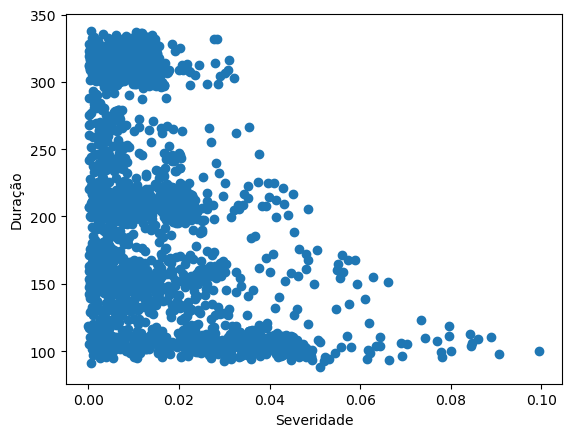

In [13]:
# Define a paleta de cores
plt.viridis()

# Adicionar rótulos aos eixos
plt.xlabel('Severidade')
plt.ylabel('Duração')

#Plota o gráfico Severidade x Duração
plt.scatter(df['Severidade'], df['Duração'])

#Salva o Gráfico no path e nome indicado
#file='scatterplot-básico-real.jpg'
#file='scatterplot-básico-util.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()


## Resultado
### Dados Numéricos de Duração x Severidade

**Base Útil**

**Base Real**

## Etapa 1 - Clusterização dos eventos de falha

O objetivo deste trecho de código é realizar a classificação dos eventos em uma escala de gravidade com base em suas características de Duração e Severidade. Como não há uma classificação pré-definida, a atribuição aleatória de categorias pode não ser a melhor abordagem. Portanto, será utilizado a clusterização por meio de diferentes algoritmos, como K-means, Hierárquico e DBSCAN, para encontrar uma categorização mais adequada e significativa para a análise da gravidade. Dado que o número de categorias necessárias não é conhecido previamente, faremos a exploração e teste de abordagens variadas de algoritmos de clusterização, considerando métricas de qualidade do cluster e a interpretação dos resultados.

Iniciaremos pelo K-means e utilizaremos a análise de Silhueta para determinar o número ideal de clusters a ser explorado e avaliado. Em seguida, aplicaremos a análise de Silhueta novamente para avaliar os clusters gerados pela clusterização hierárquica. Por fim, faremos uso da curva de inflexão para determinar o número de clusters no DBSCAN. Essas etapas nos auxiliarão na definição dos clusters mais adequados para a classificação da gravidade dos eventos.

**Coeficiente de Silhueta**
O critério de melhor cluster com base no coeficiente de Silhueta é escolher o valor que maximiza a média do coeficiente de Silhueta (CSM). O coeficiente de silhueta varia de -1 a 1, onde valores mais próximos de 1 indicam que as amostras estão bem separadas entre os clusters, enquanto valores próximos de 0 ou negativos indicam que as amostras podem estar mais próximas ou sobrepostas entre os clusters.

Portanto, ao calcular o coeficiente de silhueta para diferentes números de clusters, o objetivo é encontrar o número de clusters que maximize o valor médio do coeficiente de silhueta. Esse valor indica uma melhor separação e compactação dos clusters, resultando em uma melhor estruturação dos dados. Kaufman & Rousseeuw (1990) sugerem uma escala de interpretação para o valor de CSM. 

*Como critério definiremos que qualquer CSM que estiver acima de **0.5** poderá ser adotado para a sequência do trabalho.*

|   Valor de CSM   |              Interpretação             |
|:----------------:|:--------------------------------------:|
|   0.71 a 1.0     |  Excelente separação entre os clusters |
|   0.51 a 0.7     |    Boa separação entre os clusters     |
|   0.26 a 0.5     |   Separação fraca entre os clusters    |
| -0.25 a 0.25     | Possível sobreposição de clusters ou    |
|                  | objetos na fronteira de decisão entre  |
|                  |      dois clusters                     |
| -1.0 a -0.26     | Valores negativos indicam possível     |
|                  | atribuição incorreta dos objetos ao    |
|                  |              cluster                   |



## Código
### K-means

No código abaixo é calculado o coeficiente de silhueta médio para cada número de clusters testado e armazenado em avg_silhouettes. O número de clusters que possui o maior valor médio de coeficiente de silhueta é considerado o melhor cluster para esse conjunto de dados.

Na sequencia plotamos o gráfico com o número de cluster para a melhor Silhueta e no código seguinte plotamos para uma proposta de cinco clasters.

In [83]:
import warnings

# Ignorar o aviso específico emitido pelo KMeans de vazamento dememória
#C:\Users\wabas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: 
#KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. 
#You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
#  warnings.warn(
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")


KMeans(n_clusters=4, n_init=10)


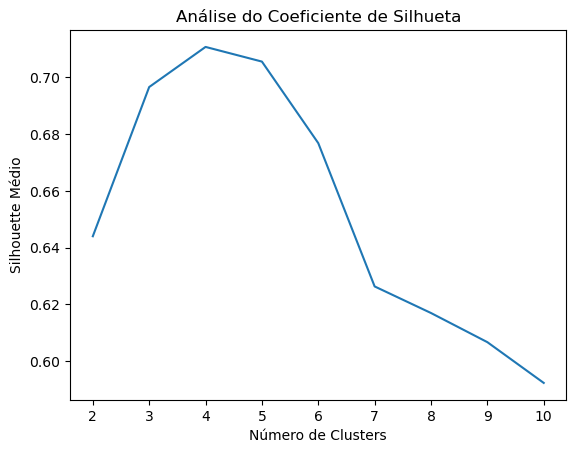

In [84]:
plt.viridis()

# Selecionar apenas as colunas numéricas para o ajuste do K-means
numeric_columns = ['Severidade', 'Duração']
numeric_df = df[numeric_columns]

# Lista para armazenar os valores médios do coeficiente de silhueta
avg_silhouettes = []
models = []
nb_clusters = range(2, 11) # faixa de clusteres a serem testados

# Loop para ajustar o modelo e calcular o coeficiente de silhueta para diferentes números de clusters
for n_clusters in nb_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10)
    kmeans.fit(numeric_df)
    labels = kmeans.predict(numeric_df)
    silhouette_avg = silhouette_score(numeric_df, labels)
    avg_silhouettes.append(silhouette_avg)
    models.append(kmeans)

# Encontrar o modelo com o maior coeficiente de silhueta
best_model_idx = avg_silhouettes.index(max(avg_silhouettes))
best_model = models[best_model_idx]
print(models[best_model_idx])


# Plotar o gráfico
plt.plot(nb_clusters, avg_silhouettes)
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Médio")
plt.title("Análise do Coeficiente de Silhueta")

#Salva o Gráfico no path e nome indicado
#file='Silhueta-real-Kmeans.jpg'
#file='Silhueta-util-Kmeans.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()


### Cluster com a melhor Silhueta - Kmeans

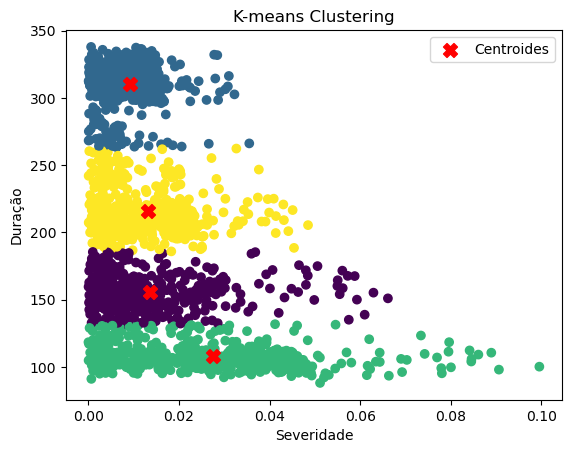

In [85]:
# Obtendo as coordenadas dos centroides do melhor modelo
centroides = best_model.cluster_centers_

# Obtendo os rótulos dos clusters do melhor modelo
rotulos = best_model.labels_

# Plotando o scatter plot dos dados
plt.scatter(df['Severidade'], df['Duração'], c=rotulos, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], marker='X', c='red', s=100, label='Centroides')
plt.xlabel('Severidade')
plt.ylabel('Duração')
plt.title('K-means Clustering')
plt.legend()

#Salva o Gráfico no path e nome indicado
#file='Cluster-2-real-Kmeans.jpg'
#file='Cluster-2-util-Kmeans.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()

### Gráfico com 5 Clusters - Kmeans

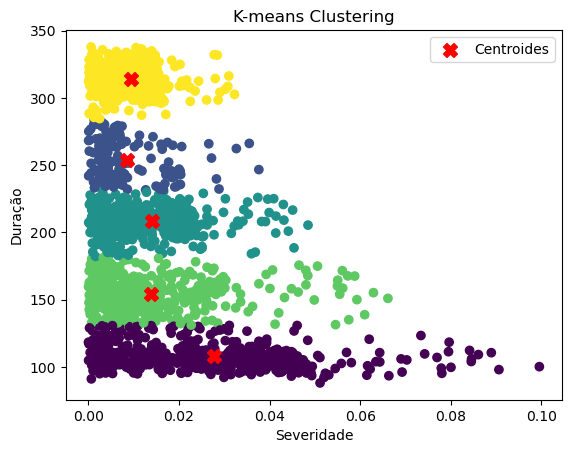

In [86]:
# Selecionar o número de Cluster 
choise_model_idx = 3 # index do número de cluster. O index 3 corresponde a 5 clusteres conforme o gráfico de Silhueta
choise_model_k = models[choise_model_idx]

# Atribuir os rótulos do modelo escolhido ao DataFrame
df['Cluster_K'] = choise_model_k.labels_

# Obtendo as coordenadas dos centroides do modelo
centroides = choise_model_k.cluster_centers_

# Obtendo os rótulos dos clusters do modelo
rotulos = choise_model_k.labels_

# Plotando o scatter plot dos dados
plt.scatter(df['Severidade'], df['Duração'], c=rotulos, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], marker='X', c='red', s=100, label='Centroides')
plt.xlabel('Severidade')
plt.ylabel('Duração')
plt.title('K-means Clustering')
plt.legend()

#Salva o Gráfico no path e nome indicado
#file='Cluster-5-real-Kmeans.jpg'
#file='Cluster-5-util-Kmeans.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()

In [87]:
# Filtrar o DataFrame pelo número do cluster desejado (por exemplo, cluster 2)
cluster_number = 2
filtered_df = df.loc[df['Cluster_K'] == cluster_number]

# Imprimir o DataFrame filtrado
display(filtered_df['texto_preprocessado'])

2       segmento e regional repetidor provocar cidade interrupção joao fibrar trecho trecho pessoa duplo rompimento provedor rede operacional span1 interrupção ótico span11 rompimento
11           causar segmento e cidade fibrar trecho trecho hub span12 vandalismo duplo instabilidade rompimento provedor reder transmissão metropolitano span1 cuiabar ótica rompimento
12                                                                                                                                  paralisação falha equipamento ocasionar transmissão
13           span3 segmento e cidade luis fibrar trecho trecho hub duplo sao instabilidade devido rompimento provedor rede operacional metropolitana span1 interrupção ótico rompimento
31                     span10 b causar segmento cidade paulo distancia fibrar trecho trecho hub duplo sao queda falha rompimento provedor rede transmissão span7 ótico longo rompimento
                                                                                

## Hierarchical Clustering

No código abaixo é calculado o coeficiente de silhueta para cada número de clusters testado e armazenado em avg_silhouettes. O número de clusters que possui o maior valor médio de coeficiente de silhueta é considerado o melhor cluster para esse conjunto de dados.

Na sequencia plotamos o gráfico com o número de cluster para a melhor Silhueta e no código seguinte plotamos para uma proposta de cinco clasters

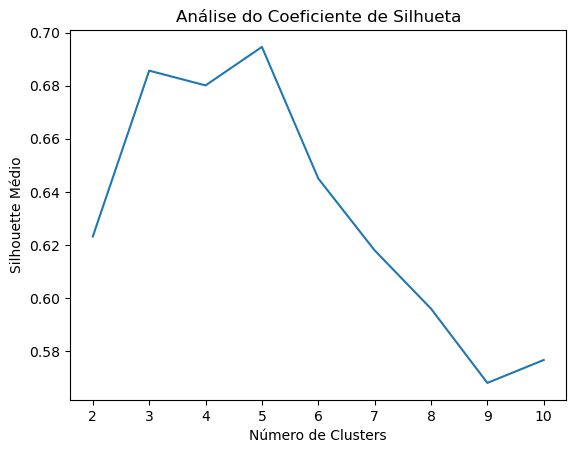

In [88]:
# Lista para armazenar os modelos
models = []

# Lista para armazenar os valores médios do coeficiente de silhueta
avg_silhouettes = []

nb_clusters = range(2, 11) # faixa de clusteres a serem testados

# Loop para ajustar o modelo hierárquico e calcular o coeficiente de silhueta para diferentes números de clusters
for n_clusters in nb_clusters:
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    hierarchical.fit(numeric_df)
    models.append(hierarchical)
    labels = hierarchical.labels_
    silhouette_avg = silhouette_score(numeric_df, labels)
    avg_silhouettes.append(silhouette_avg)

# Encontrar o índice do modelo com o maior valor de coeficiente de silhueta
best_model_idx = avg_silhouettes.index(max(avg_silhouettes))

# Acessar o melhor modelo na lista de modelos
best_model = models[best_model_idx]


# Plotar o gráfico
plt.plot(nb_clusters, avg_silhouettes)
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Médio")
plt.title("Análise do Coeficiente de Silhueta")

#Salva o Gráfico no path e nome indicado
#file='Silhueta-real-Hierarchical.jpg'
#file='Silhueta-util-Hierarchical.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()



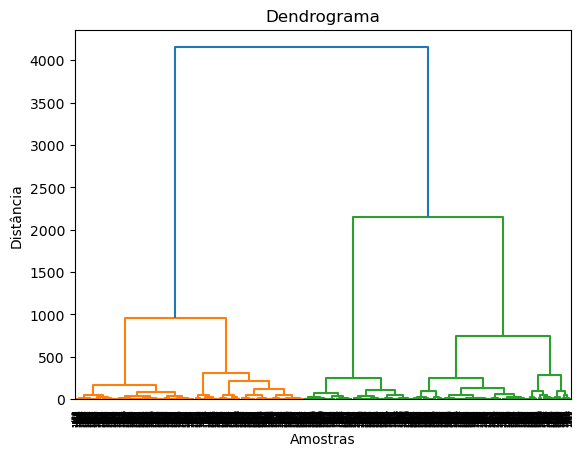

In [89]:
# Calcular a matriz de ligação (linkage matrix)
linkage_matrix = linkage(numeric_df, method='ward')

# Plotar o dendrograma
dendrogram(linkage_matrix)
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.title('Dendrograma')

#Salva o Gráfico no path e nome indicado
#file='Dendograma-util-Hierarchical.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()


### Cluster com a melhor Silhueta - Hierarchical

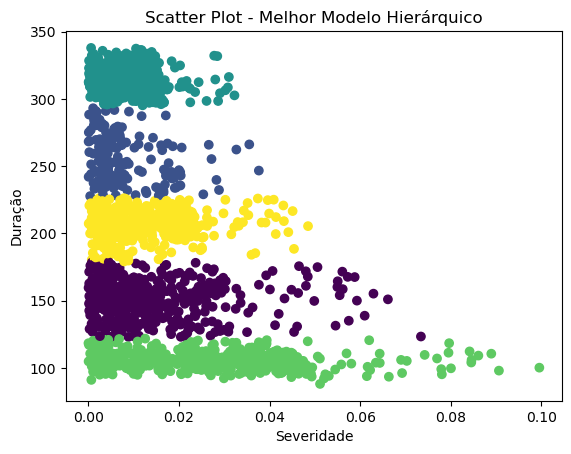

In [90]:
# Obter os rótulos dos clusters atribuídos aos dados pelo melhor modelo
best_labels = best_model.fit_predict(numeric_df)

# Plotar o scatter plot com os clusters coloridos
plt.scatter(numeric_df['Severidade'], numeric_df['Duração'], c=best_labels)
plt.xlabel('Severidade')
plt.ylabel('Duração')
plt.title('Scatter Plot - Melhor Modelo Hierárquico')

#Salva o Gráfico no path e nome indicado
#file='Cluster-2-real-Hierarchical.jpg'
#file='Cluster-2-util-Hierarchical.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()


### Gráfico com 5 Clusters - Hierarchical

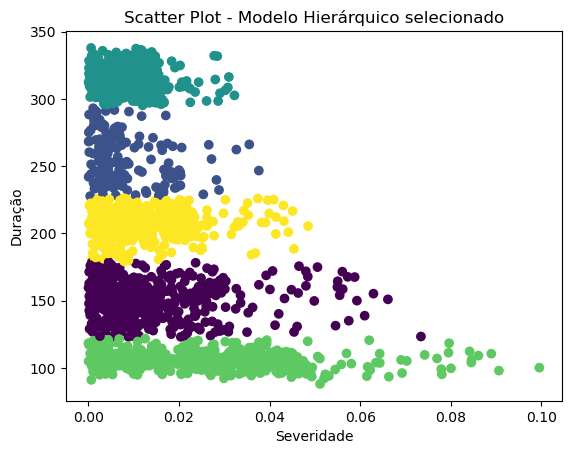

In [91]:
# Encontrar o índice 
choise_model_idx = 3

# Acessar o modelo na lista de modelos
choise_model_h = models[choise_model_idx]

# Obter os rótulos dos clusters atribuídos aos dados pelo modelo
choise_labels_h = choise_model_h.fit_predict(numeric_df)


# Atribuir os rótulos do modelo ao DataFrame
df['Cluster_H'] = choise_model_h.labels_

# Plotar o scatter plot com os clusters coloridos
plt.scatter(numeric_df['Severidade'], numeric_df['Duração'], c=choise_labels_h)
plt.xlabel('Severidade')
plt.ylabel('Duração')
plt.title('Scatter Plot - Modelo Hierárquico selecionado')

#Salva o Gráfico no path e nome indicado
#file='Cluster-5-real-Hierarchical.jpg'
#file='Cluster-5-util-Hierarchical.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()


In [92]:
# Filtrar o DataFrame pelo número do cluster desejado (por exemplo, cluster 0)
cluster_number = 2
filtered_df = df.loc[df['Cluster_H'] == cluster_number]

# Imprimir o DataFrame filtrado
display(filtered_df['texto_preprocessado'])

3         span3 problema segmento grande anel cidade distancia triplo span4 paralisação span8 fibrar trecho trecho rompimento campo provedor reder transmissão ótico ocasionar c longo rompimento
6                b segmento anel cidade span6 triplo fibrar trecho trecho span2 instabilidade devido rompimento provedor rede operacional metropolitano cuiabar ótica span11 suspensão rompimento
7                                                                                                                                              causar interrupção vandalismo operacional roteador
9        causar segmento abordagem e grande regional cidade span6 triplo paralisação span8 fibrar trecho trecho instabilidade rompimento campar provedor rede operacional ótica span11 rompimento
25      causar segmento cidade triplo paralisação fibrar trecho trecho span12 span5 instabilidade rompimento provedor reder transmissão metropolitana agregador span7 ótica brasilia c rompimento
                              

## DBSCAN

### Distância eps e curva de inflexão
No algoritmo DBSCAN, o parâmetro **eps** define a distância máxima entre dois pontos para que sejam considerados vizinhos. Essa distância influencia a densidade dos clusters e a identificação de pontos de ruído. Uma abordagem para determinar o valor de eps é encontrar o ponto de inflexão na curva de distâncias. Ao calcular a derivada das distâncias e plotar o gráfico da derivada, o ponto de inflexão é identificado e marcado. O valor de eps correspondente a esse ponto de inflexão é utilizado como a distância limite para o DBSCAN. Essa técnica permite ajustar o valor de eps com base nas características dos dados.

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

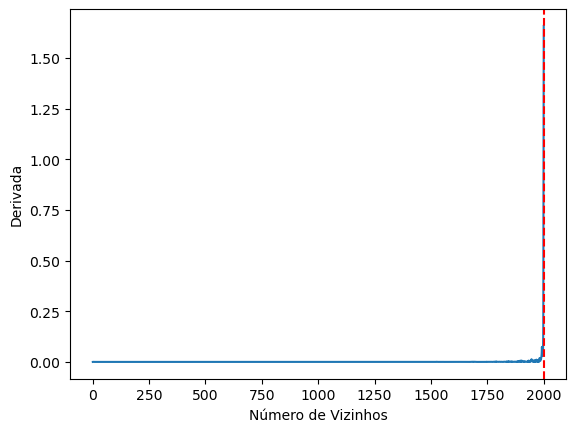

Ponto de inflexão: 2000
Valor de eps: 3.0028318337434254


In [93]:
# Calcular as distâncias
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(numeric_df)
distances, indices = nbrs.kneighbors(numeric_df)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

# Calcular a derivada das distâncias
derivative = np.gradient(distances)

# Plotar o gráfico da derivada
plt.plot(range(1, len(distances) + 1), derivative)
plt.xlabel('Número de Vizinhos')
plt.ylabel('Derivada')

# Identificar o ponto de inflexão
inflexion_point = np.argmax(derivative) + 1
plt.axvline(x=inflexion_point, color='r', linestyle='--')

#Salva o Gráfico no path e nome indicado
#file='Derivada-util-DBSACAN.jpg'
#file='Derivada-real-DBSACAN.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()

print("Ponto de inflexão:", inflexion_point)

eps = distances[inflexion_point - 1]
print("Valor de eps:", eps)


### Clusterização DBSCAN - Silhueta

O código abaixo utiliza o algoritmo DBSCAN para realizar a clusterização dos dados contidos no dataframe "numeric_df". O código executa um loop aninhado para testar diferentes valores de "min_samples" e "eps" e calcular o índice de silhueta para cada combinação. Ao final das iterações, o código seleciona o valor de "min_samples" e "eps" que resultam no maior índice de silhueta. Em seguida, o código utiliza esses valores para realizar a clusterização final dos dados e calcula o número de clusters, o número de outliers e o índice de silhueta para essa configuração ótima. Os resultados são impressos na saída.

In [100]:
min_samples = range(5, 10, 20)  # número de amostras
eps = np.arange(3, 20, 50)  # define um array variando de 50 a 400 com um passo de 50

output = []

for ms in min_samples:
    for ep in eps:
        # Realiza o cluster DBSCAN com os valores atuais de min_samples e eps
        labels = DBSCAN(min_samples=ms, eps=ep).fit(numeric_df).labels_
        
        # Verifica se o número de rótulos é maior que 1
        if len(set(labels)) > 1:
            score = silhouette_score(numeric_df, labels)
            output.append((ms, ep, score))

# Verifica se foram encontrados clusters significativos
if len(output) > 0:
    # Encontra o min_samples, eps e score com o maior silhouette_score
    min_samples, eps, score = sorted(output, key=lambda x: x[-1])[-1]

    # Verifica se o valor de min_samples e eps são diferentes de -1 (valor padrão caso não seja encontrado)
    if min_samples == -1:
        min_samples = 50
    if eps == -1:
        eps = 3

    # Imprime o melhor silhouette_score, min_samples e eps
    print(f"Melhor silhouette_score: {score}")
    print(f"min_samples: {min_samples}")
    print(f"eps: {eps}")

    # Realiza o agrupamento DBSCAN com o melhor min_samples e eps
    labels = DBSCAN(min_samples=min_samples, eps=eps).fit(numeric_df).labels_
    df['Cluester_DB'] = labels

    # Conta o número de clusters e outliers
    clusters = len(Counter(labels))-1
    num_outliers = Counter(labels)[-1]

    # Calcula o silhouette_score para o agrupamento final
    silhouette = silhouette_score(numeric_df, labels)

    # Imprime o número de clusters, número de outliers e silhouette_score
    print(f"Número de clusters: {clusters}")
    print(f"Número de outliers: {num_outliers}")
    print(f"Silhouette_score: {silhouette}")
else:
    print("Não foram encontrados clusters significativos.")


Melhor silhouette_score: 0.023588990669542988
min_samples: 5
eps: 3
Número de clusters: 1
Número de outliers: 1
Silhouette_score: 0.023588990669542988


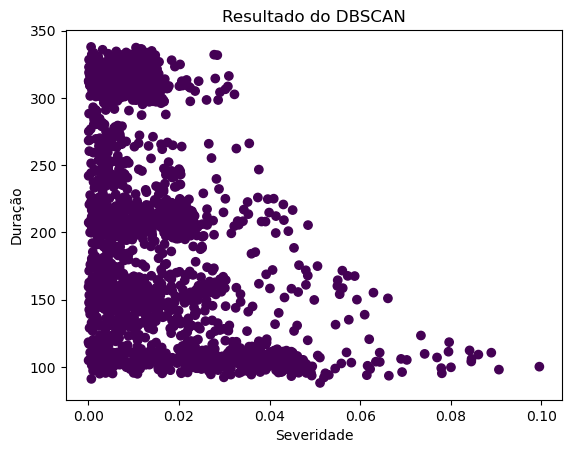

In [27]:
# Scatter plot dos dados com cores representando os clusters
plt.scatter(numeric_df['Severidade'], numeric_df['Duração'], c=labels, cmap='viridis')
plt.xlabel('Severidade')
plt.ylabel('Duração')
plt.title('Resultado do DBSCAN')

#Salva o Gráfico no path e nome indicado
#file='Cluster-real-DBSACAN.jpg'
#file='Cluster-util-DBSACAN.jpg'
#plt.savefig(path+file, format='jpg')

plt.show()

In [108]:
print(df.dtypes) # mostra os tipo de dados
print('\nShape',df.shape) #shape
print()
display(df.head()) # head do df
print()
display(df.tail()) # tails do df

# Contagem de repetições do atributo
contagem = df['Cluster_H'].value_counts()
print('\nContagem do Número de eventos por cluster\n',contagem)

Motivo                  object
Severidade             float64
Duração                float64
texto_preprocessado     object
Cluster_K                int32
Cluster_H                int64
Cluester_DB              int64
dtype: object

Shape (2000, 7)



,Motivo,Severidade,Duração,texto_preprocessado,Cluster_K,Cluster_H,Cluester_DB
0,"Falha na transmissão provocada por queda de climatização, que atingiu o hub e afetou 36 sites de acesso da cidade e região",0.002212,253.689900,atingir queda falha hub região provocar 36 cidade transmissão acesso afetar site climatização,1,1,0
1,"Instabilidade na transmissão ocasionada por vandalismo de climatização, que atingiu o agregador e afetou 88 sites de acesso da cidade e região",0.001265,283.735331,instabilidade atingir região vandalismo 88 ocasionar cidade transmissão acesso afetar site climatização agregador,1,1,0
2,"Interrupção operacional provocada por interrupção de fibra ótica, duplo rompimento na rede regional no segmento repetidor da cidade joao pessoa no provedor E, Rompimento nos trecho entre os trechos ['span1', 'span11']",0.017064,212.119142,segmento e regional repetidor provocar cidade interrupção joao fibrar trecho trecho pessoa duplo rompimento provedor rede operacional span1 interrupção ótico span11 rompimento,2,4,0
3,"Problema na transmissão ocasionada por paralisação de fibra ótica, triplo rompimento na rede longa distancia no segmento anel da cidade campo grande no provedor C, Rompimento nos trecho entre os trechos ['span4', 'span3', 'span8']",0.012593,323.142530,span3 problema segmento grande anel cidade distancia triplo span4 paralisação span8 fibrar trecho trecho rompimento campo provedor reder transmissão ótico ocasionar c longo rompimento,4,2,0
4,"Problema operacional provocada por interrupção de climatização, que atingiu o agregador e afetou 109 sites de acesso da cidade e região",0.000516,276.862848,atingir problema região interrupção provocar cidade acesso operacional afetar site 109 climatização agregador,1,1,0


,Motivo,Severidade,Duração,texto_preprocessado,Cluster_K,Cluster_H,Cluester_DB
1995,"Problema na transmissão devido a paralisação de fibra ótica, triplo rompimento na rede regional no segmento repetidor da cidade macapa no provedor A, Rompimento nos trecho entre os trechos ['span10', 'span7', 'span11']",0.013112,314.076354,span10 problema segmento o regional repetidor cidade triplo paralisação fibrar trecho trecho devido rompimento provedor macapa rede transmissão span7 ótico span11 rompimento,4,2,0
1996,Interrupção na transmissão causada por interrupção de equipamento,0.004382,317.780606,causar interrupção equipamento interrupção transmissão,4,2,0
1997,"Problema na transmissão ocasionada por queda de climatização, que atingiu o anel e afetou 35 sites de acesso da cidade e região",0.020315,235.652121,35 atingir problema queda região anel ocasionar cidade transmissão acesso afetar site climatização,1,1,0
1998,"Problema operacional devido a vandalismo de energia, que atingiu o abordagem e afetou 160 sites de acesso da cidade e região",0.012403,191.361923,devido atingir problema abordagem região 160 vandalismo cidade energio acesso operacional afetar site,2,4,0
1999,"Interrupção operacional provocada por suspensão de energia, que atingiu o anel e afetou 109 sites de acesso da cidade e região",0.016155,155.999738,atingir interrupção região anel provocar cidade energio acesso operacional afetar site suspensão 109,3,0,0



Contagem do Número de eventos por cluster
 3    483
4    465
2    440
0    440
1    172
Name: Cluster_H, dtype: int64


## Resultado

O resultado demonstra que os desempenhos de Silhuetas dos modelos de Clusterização Kmeans e Hierarchical para o número de Clusteres igual a 5 foram praticamente iguais nas bases Útel e Real. Dessa forma, adotaremos o número de Clusteres igual a 5 com a clusterização gerada pelo modelo Hierarchical, visto que, será útil observar os modelos de rede PLN performando nas mesmas condições para as duas bases.

![Slide3.svg](https://raw.githubusercontent.com/wabastos/ML_Analytics/main/Slide3.svg)

![Slide1.SVG](https://raw.githubusercontent.com/wabastos/ML_Analytics/main/Slide1.SVG)


| Cluster | Contagem | Percentagem |
|---------|----------|-------------|
| 0       | 440      | 22.00%      |
| 3       | 483      | 24.15%      |
| 2       | 440      | 22.00%      |
| 1       | 172      | 8.60%       |
| 4       | 465      | 23.25%      |


![Slide2.SVG](https://raw.githubusercontent.com/wabastos/ML_Analytics/main/Slide2.SVG)

| Cluster | Contagem | Percentagem |
|---------|----------|-------------|
|    0    |   1830   |    73.20%   |
|    3    |   287    |    11.48%   |
|    1    |   117    |    4.68%    |
|    4    |   36     |    1.44%    |
|    2    |   6      |    0.24%    |



### Base Últil


|    | Motivo                                                                                                                                                                                                                       |   Severidade |   Duração | texto_preprocessado                                                                                                                                                               |   Cluster_K |   Cluster_H |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------:|----------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------:|------------:|
|  0 | Interrupção na transmissão provocada por vandalismo de energia, que atingiu o hub e afetou 59 sites de acesso da cidade e região                                                                                             |  0.00799345  |   409.769 | interrupção afetar região acesso atingir cidade transmissão site energia hub vandalismo provocar 59                                                                               |           0 |           1 |
|  1 | Problema na infraestrutura causada por interrupção de energia, que atingiu o repetidor e afetou 81 sites de acesso da cidade e região                                                                                        |  0.00310719  |   270.863 | afetar região 81 acesso cidade interrupção causar site infraestrutura energia repetidor atingir problema                                                                          |           1 |           4 |
|  2 | Interrupção na infraestrutura devido a vandalismo de equipamento                                                                                                                                                             |  0.00614017  |   222.526 | interrupção equipamento infraestrutura devido vandalismo                                                                                                                          |           1 |           4 |
|  3 | Interrupção operacional provocada por vandalismo de fibra ótica, duplo rompimento na rede longa distancia no segmento agregador da cidade sao paulo no provedor B, Rompimento nos trecho entre os trechos ['span6', 'span7'] |  0.000940783 |   336.444 | rompimento rede vandalismo provocar trecho sao cidade span7 rompimento paulo interrupção longo fibra provedor operacional ótica duplo distancia span6 b agregador trecho segmento |           0 |           1 |
|  4 | Instabilidade na infraestrutura ocasionada por vandalismo de climatização, que atingiu o repetidor e afetou 47 sites de acesso da cidade e região                                                                            |  0.0082138   |   222.399 | afetar região acesso ocasionar cidade atingir climatização site infraestrutura repetidor instabilidade vandalismo 47                                                              |           1 |           4 |


|      | Motivo                                                                                                                                                                                                             |   Severidade |   Duração | texto_preprocessado                                                                                                                                                    |   Cluster_K |   Cluster_H |
|-----:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------:|----------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------:|------------:|
| 1995 | Falha operacional causada por paralisação de climatização, que atingiu o agregador e afetou 79 sites de acesso da cidade e região                                                                                  |   0.00631686 |   710.981 | afetar região 79 acesso cidade paralisação falha causar climatização site operacional agregador atingir                                                                |           4 |           0 |
| 1996 | Instabilidade operacional causada por vandalismo de climatização, que atingiu o hub e afetou 21 sites de acesso da cidade e região                                                                                 |   0.00672946 |   507.559 | afetar região acesso atingir cidade causar climatização site operacional instabilidade hub vandalismo 21                                                               |           2 |           3 |
| 1997 | Problema operacional provocada por queda de fibra ótica, duplo rompimento na rede regional no segmento hub da cidade salvador no provedor A, Rompimento nos trecho entre os trechos ['span5', 'span2']             |   0.00735728 |   760.547 | rompimento rede provocar span2 trecho cidade rompimento span5 problema fibrar provedor regional operacional hub salvador ótica duplo o trecho queda segmento           |           4 |           0 |
| 1998 | Problema na transmissão provocada por interrupção de fibra ótica, duplo rompimento na rede metropolitana no segmento hub da cidade macapa no provedor E, Rompimento nos trecho entre os trechos ['span6', 'span4'] |   0.0113051  |   276.346 | span4 rompimento reder macapa provocar trecho cidade rompimento metropolitana problema fibrar provedor hub e ótica duplo transmissão span6 trecho interrupção segmento |           1 |           4 |
| 1999 | Falha na infraestrutura devido a suspensão de climatização, que atingiu o agregador e afetou 173 sites de acesso da cidade e região                                                                                |   0.010323   |   411.88  | 173 afetar região acesso cidade falha climatização site infraestrutura suspensão devido agregador atingir                                                              |           0 |           1 |

### Base Real


|    | Motivo                                                                                                                                                                       |   Duração |   Severidade | texto_preprocessado                                                                                                    |   Cluster_K |   Cluster_H |   Cluester_DB |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------:|-------------:|:-----------------------------------------------------------------------------------------------------------------------|------------:|------------:|--------------:|
|  0 | defeito de energia ac no sitio centralizador z3pn5w                                                                                                                          |        50 |     0.201247 | ac centralizador sitio energia z3pn5w defeito                                                                          |           2 |           0 |             0 |
|  1 | defeito de energia ac e posterior incendio devido a uma defeito no gerador de energia acoplado no sitio centralizador z3pn5w                                                 |       542 |     0.22465  | ac incendio acoplar gerador sitio centralizador devido energia z3pn5w defeito posterior                                |           0 |           3 |             0 |
|  2 | defeito de energia ac na repetidora cod911 n2                                                                                                                                |       361 |     1.07917  | repetidorar n2 ac energia defeito cod911                                                                               |           0 |           0 |             0 |
|  3 | dupla defeito nos trechos entre os roteadores cod1472 vs cod1442 de atribuicao opseven e entre cod1357 vs bqnuntzown0cycag de atribuicao opoito                              |       274 |     1.43918  | roteador opoito cod1357 duplo bqnuntzown0cycag cod1472 atribuicao cod1442 opseven defeito vs trecho                    |           0 |           0 |             0 |
|  4 | ruptura entre os roteadores cod1472 vs cod1442 de atribuicao da opseven defeito entre cod1417 e cod1325 e defeito de infra no sitio cod1325 baixa autonomia das acumuladores |        39 |     1.27192  | roteador cod1325 baixo ruptura autonomio cod1472 sitio infra atribuicao cod1442 opseven cod1417r defeito vs acumulador |           2 |           0 |             0 |

|      | Motivo                                                                                                 |   Duração |   Severidade | texto_preprocessado                                                                  |   Cluster_K |   Cluster_H |   Cluester_DB |
|-----:|:-------------------------------------------------------------------------------------------------------|----------:|-------------:|:-------------------------------------------------------------------------------------|------------:|------------:|--------------:|
| 2271 | defeito no link de dimensionamento opfive telecom no segmento de rede entre cidade193pi vs cidade153ce |        83 |    2.70518   | rede dimensionamento cidade193pi telecom link defeito vs segmento cidade153ce opfive |           2 |           0 |             0 |
| 2272 | defeito no disjuntor geral no sitio centralizador hfieqc                                               |       210 |    0.223405  | geral centralizador sitio defeito disjuntor hfieqc                                   |           2 |           0 |             0 |
| 2273 | defeito de energia ac no sitio centralizador uh9txu com causa raiz em analise                          |       122 |    1.01904   | ac centralizador sitio causar energia analise uh9txu defeito raiz                    |           2 |           0 |             0 |
| 2274 | furto no sitio centralizador cj5i7b                                                                    |        91 |    0.0748076 | furto sitio cj5i7b centralizador                                                     |           2 |           0 |             0 |
| 2275 | defeito no enlace de microwave na repetidora ucyqld devido intemperies climaticas na regiao            |       113 |    0.245793  | repetidorar intemperie enlace climatico ucyqld devido regiaor defeito microwave      |           2 |           0 |             0 |

## Código
### Pré-Processamento e divisão da base em Treino e Teste

O código realiza o pré-processamento dos dados de texto, incluindo tokenização e preenchimento de sequências. Em seguida, os atributos categóricos são codificados e convertidos em representação one-hot. Por fim, os dados são divididos em conjuntos de treinamento e teste para posterior uso em um modelo de aprendizado de rede de PLN.

> - Fitra apenas os atributos de interesse para o filtered_df.

> - Pré-processamento de texto incluindo **tokenizer** no atributo *texto_processado* para converter o texto em sequências numéricas através do **texts_to_sequences**, em seguida calcula o comprimento máximo da sequencia e preenche com zeros aquela com comprimento menor **pad_sequences**.

> - Codificação do atributo *gravidade* usando o objeto **LabelEncoder**, através do método fit_transformer, para codificar as classes do atributo Cluster em números inteiros. Em seguida as classes do atributo são convertidas em codificação **one-hot** através do método to_categorical.

> - Transformação das variáveis *Duração e Severidade* por redimensionamento escalar usando o método fit_transform() do objeto **MinMaxScaler**.

> - Divisão dos dados em treinamento e teste usando o método train_test_split() para obter os conjuntos: X_train, X_test, text_train, text_test, gravidade_train, gravidade_test, duracao_train, duracao_test, severidade_train e severidade_test 

*Obs: o modelo final poderá não ter todos os atributos acima codificados (Duração e Severidade). Na verdade, espea-se que  não estejam, significando que a prioridade 1 dos objetivos desse trabalho seria atendido.*


In [29]:
filtered_df = df[['texto_preprocessado','Duração','Severidade','Cluster_H']]
filtered_df = filtered_df.rename(columns={'Cluster_H': 'Cluster'})
print(filtered_df.shape)  # Imprime a forma do DataFrame filtrado

(2000, 4)


In [30]:
# Pré-processamento de texto
tokenizer = Tokenizer()  # Cria um objeto Tokenizer
tokenizer.fit_on_texts(filtered_df['texto_preprocessado'])  # Ajusta o tokenizer aos textos e cria um vocabulário com base nas palavras encontradas nos textos
encoded_text = tokenizer.texts_to_sequences(filtered_df['texto_preprocessado'])  # Converte os textos em sequências numéricas
max_sequence_length = max(len(seq) for seq in encoded_text)  # Calcula o comprimento máximo da sequência
padded_text = pad_sequences(encoded_text, maxlen=max_sequence_length, padding='post')  # Preenche as sequências com zeros

# Codificação do atributo 'gravidade'
label_encoder_gravidade = LabelEncoder()  # Cria um objeto LabelEncoder
encoded_gravidade = label_encoder_gravidade.fit_transform(filtered_df['Cluster'])  # Codifica as classes em números inteiros
num_classes_gravidade = len(label_encoder_gravidade.classes_)  # Obtém o número de classes únicas
one_hot_gravidade = to_categorical(encoded_gravidade, num_classes=num_classes_gravidade)  # Converte as classes em codificação one-hot

# Transformação da variável 'Duração'
scaler = MinMaxScaler()
scaled_duracao = scaler.fit_transform(filtered_df['Duração'].values.reshape(-1, 1))

# Transformação da variável 'Severidade'
scaled_severidade = scaler.fit_transform(filtered_df['Severidade'].values.reshape(-1, 1))

# Divisão dos dados em treinamento e teste
X_train, X_test, text_train, text_test, gravidade_train, gravidade_test, duracao_train, duracao_test, severidade_train, severidade_test = train_test_split(
    padded_text, filtered_df['texto_preprocessado'], one_hot_gravidade, 
                                       scaled_duracao, scaled_severidade, test_size=0.2, random_state=42)

## Código
### Arquitetura do modelo

Este código define a arquitetura de um modelo de rede neural de PLN que combina processamento de texto com atributos adicionais (Duração e Severidade) para realizar uma classificação de Gravidade. O texto de entrada é pré-processado, transformado em vetores de palavras usando uma camada de embedding, e passa por uma camada de convolução e pooling para extrair recursos relevantes. Os atributos adicionais são incorporados no modelo por meio de camadas de entrada separadas. Esses recursos combinados são então alimentados em uma camada densa e, finalmente, classificados usando uma camada de saída com ativação softmax. O modelo é compilado com função de perda categórica cruzada, otimizador Adam e métricas de acurácia.
Este código define a arquitetura de um modelo de rede neural com as seguintes camadas:

> - Camada de entrada: é definida com a forma (max_sequence_length,) que define o comprimento máximo da sequência de entrada para a Camada de embedding.

> - Camada de embedding: transforma as palavras de entrada em vetores densos de tamanho 100.

> - Camada de convolução 1D: realiza convolução unidimensional nos vetores de embedding para extrair recursos relevantes.

> - Camada de pooling: realiza pooling máximo unidimensional para reduzir a dimensionalidade dos recursos extraídos.

> - Camada de entrada de duração: recebe uma entrada unidimensional com tamanho 1, representando a duração do evento.

> - Camada de entrada de severidade: recebe uma entrada unidimensional com tamanho 1, representando a severidade do evento.

> - Camada de concatenação: combina os recursos extraídos da camada de pooling, a entrada de duração e a entrada de severidade em uma única representação. Nesse ponto da rede as camadas de duração e/ou severidade podem não ser adicionadas a depender da fase de construção e avaliação do modelo para atingir a maior prioridade do objetivo desse trabalho.

> - Camada densa: aplica uma transformação linear aos recursos combinados usando uma função de ativação ReLU para aprender padrões mais complexos. Aqui o parâmetro **units** deverá ser alterado para se obter melhor adaptação da rede.

> - Camada de saída: realiza a classificação multiclasse usando uma função de ativação softmax para gerar probabilidades para cada classe de gravidade.

> - Criação do modelo: define o modelo de rede neural com as camadas de entrada e saída.

> - Compilação do modelo: especifica a função de perda, otimizador e métricas de avaliação a serem usadas durante o treinamento.

> - Resumo do modelo: imprime um resumo do modelo, exibindo as camadas e o número de parâmetros treináveis.

A depender de qual cenário de prioridade (1, 2 e 3) desejmos executar é possível escolher alterando as linhas de código conforme indicado nos comentários do código.

Relembrando que:

- Prioridade 1 - usa o aprndizado apenas do Texto
- Prioridade 2 - acrescenta a Duração ao aprendizado
- Prioridade 3 - acrescenta a Duração e Severidade ao aprendizado


In [31]:
# Arquitetura do modelo
input_text = Input(shape=(max_sequence_length,))

# Camada de embedding para representação vetorial das palavras
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100)(input_text)

# Camada de convolução 1D para extração de recursos
conv_layer = Conv1D(filters=16, kernel_size=3, activation='relu')(embedding_layer)

# Camada de pooling para redução da dimensionalidade
pooling_layer = GlobalMaxPooling1D()(conv_layer)

# Camada adicionais de Duração e Severidade usados nas Prioridades 2 e 3
input_duracao = Input(shape=(1,)) 
input_severidade = Input(shape=(1,))

# Camada de concatenação para combinar os recursos extraídos com a duração e severidade

#concat_layer = Concatenate()([pooling_layer, input_duracao, input_severidade]) # Prioridade 3
#concat_layer = Concatenate()([pooling_layer, input_duracao]) # Prioridade 2
#concat_layer = Concatenate()([pooling_layer, input_severidade])
concat_layer = Concatenate()([pooling_layer]) # Prioridade 1

# Camada densa com função de ativação ReLU para aprendizado de padrões
# units=1024 quando incluido Duração e/ou Severidade
# units=2048 quando NÂO incluindo Duração e Severidade
dense_layer = Dense(units=2048, activation='relu')(concat_layer)

# Camada de saída com função de ativação softmax para classificação multiclasse
output_layer = Dense(units=num_classes_gravidade, activation='softmax')(dense_layer)

# Criação do modelo com as camadas de entrada e saída

#model = Model(inputs=[input_text, input_duracao, input_severidade], outputs=output_layer) # Prioridade 3
#model = Model(inputs=[input_text, input_duracao], outputs=output_layer) # Prioridade 2
#model = Model(inputs=[input_text, input_severidade], outputs=output_layer)
model = Model(inputs=[input_text], outputs=output_layer) # Prioridade 1

# Compilação do modelo com a função de perda, otimizador e métricas de avaliação
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()  # Imprime um resumo do modelo



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 100)           29100     
                                                                 
 conv1d (Conv1D)             (None, 22, 16)            4816      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 concatenate (Concatenate)   (None, 16)                0         
                                                                 
 dense (Dense)               (None, 2048)              34816     
                                                             

## Código
### Treino do modelo em épocas

O número de épocas podera ser alterado de maneira a se avaliar os valores de através da acurácia e função de perda.
Aqui estamos usando o a parada antecipada, contudo é possível removê-lo retirando o parâmetro callbacks=[early_stop] do código.

In [32]:
# Define os parâmetros de maximização de acurácia para antecipada para o treinamento
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

'''
# Treinamento do modelo incluindo duração e severidade - Prioridade 3
model.fit([X_train, duracao_train,severidade_train],
          gravidade_train, 
          validation_data=([X_test, duracao_test,severidade_test], gravidade_test),
          epochs=30, 
          batch_size=32
          ,callbacks=[early_stop])


# Treinamento do modelo incluindo duração - Prioridade 2
model.fit([X_train, duracao_train],
          gravidade_train, 
          validation_data=([X_test, duracao_test], gravidade_test),
          epochs=30, 
          batch_size=32
          ,callbacks=[early_stop])


# Treinamento do modelo incluindo severidade
model.fit([X_train, severidade_train],
          gravidade_train, 
          validation_data=([X_test, severidade_test], gravidade_test),
          epochs=100, 
          batch_size=32
          ,callbacks=[early_stop])

'''
# Treinamento do modelo com Prioridade 1
model.fit([X_train],
          gravidade_train, 
          validation_data=([X_test], gravidade_test),
          epochs=50, 
          batch_size=32
          ,callbacks=[early_stop])


Epoch 1/50
50/50 [==============================] - 1s 7ms/step - loss: 1.3375 - accuracy: 0.4356 - val_loss: 1.0740 - val_accuracy: 0.6450
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.8028 - accuracy: 0.7106 - val_loss: 0.6663 - val_accuracy: 0.7425
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5476 - accuracy: 0.7869 - val_loss: 0.6145 - val_accuracy: 0.7775
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4881 - accuracy: 0.7981 - val_loss: 0.5852 - val_accuracy: 0.7775
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4636 - accuracy: 0.8100 - val_loss: 0.6585 - val_accuracy: 0.7425
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4383 - accuracy: 0.8175 - val_loss: 0.6197 - val_accuracy: 0.7775
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4173 - accuracy: 0.8344 - val_loss: 0.6336 - val_accuracy: 0.7625
Epoch 8/50
50/50 [==

In [33]:
# Avaliação do modelo
'''
# Prioridade 3
loss, accuracy = model.evaluate([X_test, np.array(duracao_test).reshape(-1, 1), 
                                np.array(severidade_test).reshape(-1, 1)],
                                gravidade_test)
'''
#loss, accuracy = model.evaluate([X_test, np.array(duracao_test).reshape(-1, 1)],gravidade_test) # Prioridade 2
loss, accuracy = model.evaluate([X_test],gravidade_test) # Prioridade 1

print("\nLoss:", loss)
print("\nAccuracy:", accuracy)


13/13 [==============================] - 0s 1ms/step - loss: 0.7605 - accuracy: 0.7625

Loss: 0.7605076432228088

Accuracy: 0.762499988079071


## Resultado
### Rede Neural PLN: Conv + Dense(Relu) + Dense (Softmax)

As redes foram testadas em três configurações de composição da camada Dense(Relu): 
- sem nenhum input de Duração e Severidade - Prioridade 1
- com input de Duração e 2048 units na camada densa - Prioridade 2
- com input de Duração e Severidade - Prioridade 3
- adicionalmente foi testado com input de severidade - não considerado no resultado

Os resultados obtidos para as bases de dados Útil e Real foram analisados com relação nos objetivos estabelecidos no início do estudo. A métrica utilizada para avaliar o desempenho das redes foi a acurácia (val_accuracy), e foram estabelecidos os seguintes critérios de sucesso: alcançar uma acurácia de 70% para o nível de prioridade 1, 80% para o nível de prioridade 2 e 90% para o nível de prioridade 3.

No caso da base de dados Útil, observamos que os resultados de acurácia para o cenário de prioridade 1 foram superiores a 70%, o que indica que a rede foi capaz de cumprir o critério estabelecido. No entanto, para os cenários de prioridade 2 e 3, em que as redes foram apoiadas por camadas de dados numéricos, Duração e Severidade, os resultados de acurácia foram melhores, como era esperado. Isso se deve a natureza dos dados numéricos, que fornecem informações adicionais e complementares a semântica do texto, permitindo um aprendizado mais robusto sobre os padrões que definem as classificações de gravidade.

Embora o valor mínimo de 90% de acurácia não tenha sido alcançado para a Base Útil, isso não foi considerado um problema relevante, uma vez que o critério de 70% de acurácia para a prioridade 1 foi atingido. Os resultados obtidos para os cenários de maior prioridade foram satisfatórios e demonstram a capacidade das redes em aprender com os dados numéricos adicionais.

Para a Base Real, todos os resultados atingiram o critério mínimo de validação para a acurácia da rede, o que sugere uma correlação alta entre a semântica do texto e os valores de duração e severidade das falhas, e consequentemente, com a classificação de gravidade.

Esses resultados indicam que a rede neural foi capaz de aprender e capturar efetivamente os padrões presentes nos dados textuais, bem como utilizar as informações numéricas de Duração e Severidade para melhorar a precisão das classificações de gravidade.

Essa correlação significativa entre os dados textuais e os atributos numéricos é promissora e reforça a importância desses atributos na determinação da gravidade das falhas. Isso proporciona insights valiosos para compreender melhor os fatores que influenciam a classificação de gravidade e pode auxiliar na tomada de decisões mais precisas em relação a resolução e priorização de problemas.

No entanto, é importante continuar monitorando e avaliando o desempenho da rede com base em métricas relevantes, bem como realizar análises adicionais para verificar a consistência dos resultados e a robustez do modelo em diferentes cenários.




### Base Útil
##### Prioridade 1 - apenas texto na rede neural (units=2048)
**Treinamento**:

Epoch 50/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0185 - accuracy: 0.9900 - val_loss: 2.3071 - **val_accuracy: 0.7400**

**Teste**:

4/4 [==============================] - 0s 2ms/step - loss: 2.3071 - accuracy: 0.7400

Loss: 2.3071091175079346

Accuracy: 0.7400000095367432

#### Prioridade 2 - inclui apenas a Duração na rede neural (units=2048)
**Treinamento**:

Epoch 30/30

13/13 [==============================] - 0s 5ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.6795 - **val_accuracy: 0.8000**

**Teste**:

4/4 [==============================] - 0s 2ms/step - loss: 1.6795 - accuracy: 0.8000

Loss: 1.6794922351837158

Accuracy: 0.800000011920929

##### Prioridade 3 - inclui Duração e Severidade na rede neural (units=2048)
**Treinamento**:

Epoch 30/30

13/13 [==============================] - 0s 8ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 1.4279 - **val_accuracy: 0.8000**

**Teste**:

4/4 [==============================] - 0s 2ms/step - loss: 1.4279 - accuracy: 0.8000

Loss: 1.4279191493988037

Accuracy: 0.800000011920929

# 


### Base Real
##### Prioridade 1 - apenas texto na rede neural (units=2048)
**Treinamento**:

Epoch 50/50

57/57 [==============================] - 0s 6ms/step - loss: 0.1325 - accuracy: 0.9516 - val_loss: 1.3852 - **val_accuracy: 0.7412**

**Teste**:

15/15 [==============================] - 0s 2ms/step - loss: 1.3852 - accuracy: 0.7412

Loss: 1.3851925134658813

Accuracy: 0.7412280440330505

##### Prioridade 2 - inclui apenas a Duração na rede neural (units=1024)
**Treinamento**:

Epoch 30/30

57/57 [==============================] - 0s 6ms/step - loss: 0.0309 - accuracy: 0.9885 - val_loss: 0.3354 - **val_accuracy: 0.8925**

**Teste**:

15/15 [==============================] - 0s 2ms/step - loss: 0.3354 - accuracy: 0.8925

Loss: 0.3354094624519348

Accuracy: 0.8925438523292542

##### Prioridade 3 - inclui Duração e Severidade na rede neural (units=1024)
**Treinamento**:

Epoch 30/30

57/57 [==============================] - 0s 7ms/step - loss: 0.0218 - accuracy: 0.9923 - val_loss: 0.2777 - **val_accuracy: 0.8947**

**Teste**:

15/15 [==============================] - 0s 2ms/step - loss: 0.2777 - accuracy: 0.8947

Loss: 0.2777339518070221

Accuracy: 0.8947368264198303


## Resultado
### Uso da técnica EarlyStoping

Com o objetivo de evitar o overfitting e garantir uma boa generalização, aplicamos a técnica de EarlyStopping durante o treinamento do modelo. Essa técnica interrompe o treinamento prematuramente com base em uma condição específica. No nosso caso, utilizamos a maximização da acurácia no conjunto de teste como métrica para interromper o treinamento quando essa métrica não melhora por um número definido de épocas consecutivas, que foi de 10 épocas no nosso caso.

O código a seguir mostra a utilização do EarlyStopping no treinamento do modelo:

```python
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
```

Em resumo, o EarlyStopping é uma técnica que nos ajuda a evitar treinar o modelo por um tempo excessivo quando a métrica monitorada para de melhorar. Isso ajuda a prevenir o overfitting e obter um modelo que generalize bem para dados não vistos.

Ao aplicarmos o EarlyStopping em nosso trabalho, observamos que os resultados obtidos foram semelhantes com e sem o uso dessa técnica. No entanto, houve uma pequena vantagem em termos de redução do tempo de treinamento. É importante ressaltar que essa vantagem foi mínima, uma vez que o modelo já convergia em cerca de 30 a 50 épocas sem o EarlyStopping e em aproximadamente 15 épocas quando o utilizamos.


#### Base Útil:
**Treinamento**:

Epoch 13/50

50/50 [==============================] - 0s 4ms/step - loss: 0.3271 - accuracy: 0.8712 - val_loss: 0.7563 - **val_accuracy: 0.7650**

Epoch 13: early stopping

**Teste**:

13/13 [==============================] - 0s 2ms/step - loss: 0.8257 - accuracy: 0.7525

Loss: 0.8256950378417969

Accuracy: 0.7524999976158142

## Uso de dataset para validação

Nessa fase do projeto faremos uma validação para um Dataset nunca oferecimo ao modelo anteriormente e que não foi "clusterizado", portanto, não há uma referência prévia de qual Cluster de Gravidade o texto pertenceria. Aqui também submeteremos bases de validação com dados dito Útil e Real. Após aplicar os dados ao modelo, iremos realizar uma comparação de distribuíção dos resultados obtidos com as distribuíções de gravidades das bases que treinaram os modelos.

## Código

O código de pré-processamento das bases de validação será o mesmo aplicados as bases de treino. Portanto, não faremos a descrição do processo.

### Leitura do dataset

In [14]:
# Ler o arquivo CSV e criar um DataFrame

#file='Dados_validação_real.csv'
#file='Dados_validação_util.csv'
url='https://raw.githubusercontent.com/wabastos/ML_Analytics/main/Dados_valida%C3%A7%C3%A3o_util.csv'
df_test = pd.read_csv(url,encoding='ISO-8859-1',sep=';')

if df_test['Severidade'].dtype == 'object': # testa se os dados foram importados como string e converte para float
    df_test['Severidade'] = df_test['Severidade'].str.replace(',', '.').astype(float)
    df_test['Duração'] = df_test['Duração'].astype(float)
df_test['Severidade'] = df_test['Severidade']/df['Duração']

# Exibir o DataFrame
print(df_test.dtypes)
print(df_test.shape)

Motivo         object
Severidade    float64
Duração       float64
dtype: object
(500, 3)


### Pré-processamento

In [36]:
# Aplicar a função preprocess_text à coluna 'Causa' do DataFrame 'df' e salvar o resultado em 'texto_preprocessado'
df_test['texto_preprocessado'] = df_test['Motivo'].apply(preprocess_text)

# Uso da função de lematização na coluna 'texto_preprocessado' do DataFrame 'df' e salvar o resultado em 'texto_lemmatized'
df_test['texto_preprocessado'] = df_test['texto_preprocessado'].apply(lemmatize_text)

# Converter todas as palavras em minúsculas na coluna 'texto_lemmatized' do DataFrame 'df'
df_test['texto_preprocessado'] = df_test['texto_preprocessado'].apply(lambda x: ' '.join([word.lower() for word in x]))


### Avaliando os dados

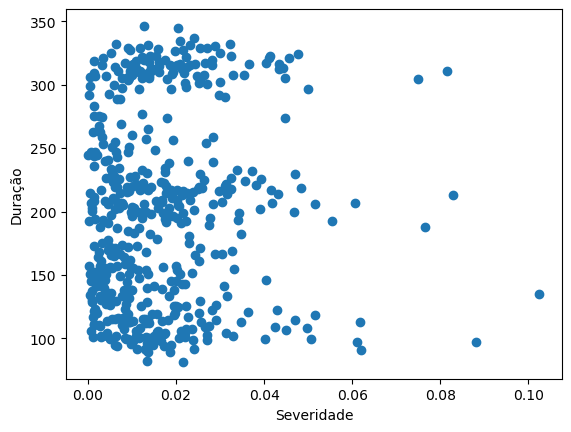

In [37]:
plt.viridis()

# Adicionar rótulos aos eixos
plt.xlabel('Severidade')
plt.ylabel('Duração')
plt.scatter(df_test['Severidade'], df_test['Duração'])

#Salva o Gráfico no path e nome indicado
file='Teste-scartterplot-util-.jpg'
plt.savefig(path+file, format='jpg')

plt.show()

### Pré-processamento e Predição

In [38]:
# Pré-processamento do DataFrame externo
# Realiza o pré-processamento semelhante ao DataFrame de treinamento para o atributo "texto_preprocessado"


# Pré-processamento de texto
tokenizer = Tokenizer()  # Cria um objeto Tokenizer
tokenizer.fit_on_texts(df_test['texto_preprocessado'])  # Ajusta o tokenizer aos textos
encoded_text = tokenizer.texts_to_sequences(df_test['texto_preprocessado'])  # Converte os textos em sequências numéricas
#max_sequence_length = max(len(seq) for seq in encoded_text)  # Calcula o comprimento máximo da sequência
padded_text = pad_sequences(encoded_text, maxlen=max_sequence_length, padding='post')  # Preenche as sequências com zeros


# Transformação da variável 'Duração'
scaler = MinMaxScaler()
scaled_duracao = scaler.fit_transform(df_test['Duração'].values.reshape(-1, 1))

# Transformação da variável 'Severidade'
scaled_severidade = scaler.fit_transform(df_test['Severidade'].values.reshape(-1, 1))

# Previsão da gravidade
#predictions = model.predict([padded_text, scaled_duracao,scaled_severidade]) #Prioridade 3
#predictions = model.predict([padded_text, scaled_duracao]) # Prioridade 2
#predictions = model.predict([padded_text, scaled_severidade])
predictions = model.predict([padded_text]) #Prioridade 1

# Decodificação das previsões
decoded_predictions = label_encoder_gravidade.inverse_transform(np.argmax(predictions, axis=1))

# Adicione as previsões ao DataFrame externo
df_test['Gravidade_Prevista'] = decoded_predictions

# Contagem de repetições do atributo
contagem = df_test['Gravidade_Prevista'].value_counts()

print(contagem)
#print(external_df.to_markdown())

16/16 [==============================] - 0s 1ms/step
3    179
4    157
2     95
0     38
1     31
Name: Gravidade_Prevista, dtype: int64


## Resultado
### Datase de Validação


Os resultados apresentados mostram tabelas comparativas entre os achados obtidos pela predição nos cenários de prioridade 1 e os resultados da clusterização usada na base de treino. Observamos que existe um equilíbrio na distribuição dos dados previstos em relação aos clusters da base de treino, tanto na Base Útil quanto na Base Real. Isso sugere uma correspondência adequada entre as previsões e os clusters originais.

Embora não possamos tirar conclusões precisas sobre a acurácia dos resultados devido a limitação de não ter realizado a clusterização prévia dos eventos em classes de gravidade, podemos inferir, com base na diferença percentual dos grupos, que houve uma distribuição adequada dos dados nos clusters. Além disso, é importante ressaltar que os dados de validação da Base Real foram coletados em uma janela de tempo diferente dos dados de treino, o que pode afetar a correlação entre eles.

No entanto, isso não representa necessariamente um problema, uma vez que o objetivo deste trabalho é avaliar a viabilidade do uso de redes neurais PLN para prever o grau de impacto causado por falhas de rede. Essa técnica pode ser especialmente útil no momento em que a falha está ocorrendo, quando ainda não se conhece a duração e a severidade. Embora a precisão do impacto seja um KPI importante, ela pode ser obtida por outros meios. O foco principal é explorar a capacidade da rede neural em fornecer previsões confiáveis para o grau de impacto.

Base Útil - Prioridade 1 vs Cluster


| Cluster | Útil Prioridade 1 | Percentagem | Custer Útil | Percentagem | Diferença Percentual |
|---------|------------------|-------------|-------------|-------------|---------------------|
|    2    |       151        |   30.20%    |    440      |   22.00%    |       8.20%         |
|    0    |       121        |   24.20%    |    440      |   22.00%    |       2.20%         |
|    3    |       105        |   21.00%    |    483      |   24.15%    |      -3.15%         |
|    1    |        98        |   19.60%    |    172      |    8.60%    |      11.00%         |
|    4    |        25        |    5.00%    |    465      |   23.25%    |     -18.25%         |
|  **Total**  |       500        |    100%     |   2.000     |    100%     |        -            |


Base Real - Prioridade 1 vs Cluster


| Cluster | Real Prioridade 1 | Percentagem  | Cluster Real | Percentagem  | Diferença Percentual |
|---------|----------------------------|------------------------------|-------------------------|----------------------------|----------------------|
|    0    |            730             |           85.58%             |           1830            |          80.40%            |        5.18%        |
|    3    |            69              |           8.08%              |           287             |          12.60%            |        -4.52%         |
|    4    |            44              |           5.15%              |           36              |          1.58%             |        3.57%          |
|    1    |            10              |           1.17%              |           117             |          5.14%             |        -3.97%         |
|    2    |            -               |              -               |           6               |          0.26%             |         -0.26%        |
|  Total  |           853              |           100%             |          2276             |         100%            |        -          |



## Trabalho Extra

Como forma de buscar outros caminhos e até para validar os modelos gerados, experimentamos o uso de rede LSTM como alternativa as rede convolucionais em PLN. Foram utilizadas as mesmas técnicas de pré-processamento e metodologia de clusterização dos dados para que a base de comparação dos resultados fossem válidas.

### Código LSTM

Neste código, exploramos o uso de redes LSTM (Long Short-Term Memory) como alternativa para as redes convolucionais em Processamento de Linguagem Natural (PLN). Seguindo a mesma metodologia de pré-processamento e clusterização dos dados, criamos uma arquitetura de modelo LSTM para prever a gravidade de falhas de rede.

```python
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping


# Arquitetura do modelo
input_text = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100)(input_text)

lstm_layer = LSTM(units=64)(embedding_layer)

input_duracao = Input(shape=(1,))
input_severidade = Input(shape=(1,))
#concat_layer = Concatenate()([lstm_layer, input_duracao, input_severidade])
concat_layer = Concatenate()([lstm_layer])

dense_layer = Dense(units=4096, activation='relu')(concat_layer)

output_layer = Dense(units=num_classes_gravidade, activation='softmax')(dense_layer)

#model = Model(inputs=[input_text, input_duracao, input_severidade], outputs=output_layer)
model_lstm = Model(inputs=[input_text], outputs=output_layer)

# Compilação do modelo com a função de perda, otimizador e métricas de avaliação
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.summary()  # Imprime um resumo do modelo

# Treinamento do modelo
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

history = model_lstm.fit(
#    x=[X_train, duracao_train, severidade_train],  # Dados de entrada
    x=[X_train],  # Dados de entrada
    y=gravidade_train,  # Classes de destino
    batch_size=32,  # Tamanho do lote de treinamento
    epochs=70,  # Número de épocas de treinamento
#    validation_data=([X_test, duracao_test, severidade_test], gravidade_test)  # Dados de validação
    validation_data=([X_test], gravidade_test),  # Dados de validação
    callbacks=[early_stop]
)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
```
O modelo é composto por camadas de embedding, uma camada LSTM, camadas de entrada para duração e severidade, uma camada de concatenação e camadas densas. Utilizamos a função de perda de entropia cruzada categórica, otimizador Adam e métricas de acurácia para compilar o modelo.

Em seguida, realizamos o treinamento do modelo usando os dados de treinamento e validação. Utilizamos o callback EarlyStopping para interromper o treinamento, caso a acurácia de validação pare de melhorar após um determinado número de épocas.

Ao longo do treinamento, registramos a acurácia e a perda tanto nos dados de treinamento quanto nos dados de validação. Essas métricas nos ajudam a avaliar o desempenho do modelo e identificar possíveis problemas de overfitting ou underfitting.

No final, obtemos as curvas de acurácia e perda para análise. Essas informações podem ser usadas para avaliar o desempenho do modelo LSTM na tarefa de previsão da gravidade das falhas de rede.

### Resultado

*Aplicado a Base Útil e cenário de prioirdade 1 obtivemos com o uso da rede LSTM um resultado similar ao obtido com rede convolucional.*

Epoch 15/70

50/50 [==============================] - 1s 12ms/step - loss: 0.4938 - accuracy: 0.7844 - val_loss: 0.6371 - **val_accuracy: 0.7650**

Epoch 15: early stopping


### Aplicando Validação Cruzada

Uma outra iniciativa foi a aplicação de validação cruzada no treinamento de modelos de Processamento de Linguagem Natural para permitir uma avaliação mais robusta do desempenho do modelo. Ao utilizar a validação cruzada, foi possível reduzir o viés de seleção do conjunto de treinamento e obter estimativas mais confiáveis do desempenho médio em diferentes conjuntos de dados. No entanto, essa abordagem também trouxe um aumento no custo computacional e do tempo de execução, pois cada fold da validação cruzada exigia o treinamento do modelo separadamente. Apesar desses desafios, a aplicação da validação cruzada permitiu uma análise mais abrangente e robusta do desempenho dos modelos de PLN, que assegurou os resultados obtidos com as redes convolucionais visto que os resultados finais de acurácia e validação foram muito semelhantes. 

```python
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import f1_score
from keras.layers import MaxPooling1D
from keras.layers import Flatten

# Função para criar o modelo Keras
def create_model():
    # Arquitetura do modelo
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_shape=(max_sequence_length,)))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=2048, activation='relu'))
    model.add(Dense(units=num_classes_gravidade, activation='softmax'))

    # Compilação do modelo com a função de perda, otimizador e métricas de avaliação
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    return model

# Defina os dados de entrada X e os rótulos y corretamente
X = X_train
y = gravidade_train

# Crie o objeto KerasClassifier
keras_clf = KerasClassifier(model=create_model, epochs=50, verbose=1)

# Realize a validação cruzada
scores = cross_val_score(keras_clf, X, y, cv=5, scoring='f1_weighted', error_score='raise')

# Imprima as métricas de avaliação para cada fold
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")

# Calcule a média das métricas de avaliação
mean_score = scores.mean()
print(f"Média das métricas: {mean_score}")
```

- Fold 1: 0.6959031323971194
- Fold 2: 0.6460196399345335
- Fold 3: 0.7628770275829099
- Fold 4: 0.759682152959464
- Fold 5: 0.7164444444444443
- Média das métricas: 0.7161852794636943


## Conclusão Final

A execução deste trabalho foi, sem dúvida, um desafio significativo, pois buscou combinar o conhecimento de telecomunicações - um campo complexo devido a sua ampla variedade tecnológica e combinações de falhas - com as técnicas de Aprendizado de Máquina (ML) e Inteligência Artificial (IA), que apenas por si, já são desafiadoras devido a vasta gama de possibilidades, complexidade e necessidade de conhecimentos específicos.

Ao conjulgar o mundo falhas da telecomunicações e ML/AI, enfrentamos uma série de desafios, como compreender a natureza das falhas de rede, mesmo com a limitação de confidencialidade dos dados, identificar e extrair características relevantes dos dados, projetar modelos adequados e interpretar corretamente os resultados. Além disso, o trabalho envolveu a aplicação de técnicas de pré-processamento, seleção de recursos, treinamento de modelos e avaliação de desempenho.

Ao superar esses desafios, obtivemos resultados relevantes que demonstraram a utilidade e o potencial das técnicas de ML/AI na previsão do grau de gravidade ou impacto causado por falhas de rede. Essa abordagem pode ser uma ferramenta poderosa para auxiliar na tomada de decisões e no gerenciamento eficaz de incidentes de rede.

No entanto, reconhecemos que é apenas uma iniciativa bem intecionada e ainda existe espaço para melhorias e aprimoramentos contínuos. uma vez que novas técnicas e algoritmos são desenvolvidos, é importante estar atualizado e explorar abordagens mais avançadas para obter resultados ainda mais precisos e confiáveis.

Em resumo, a execução desse trabalho representou um desafio significativo devido a combinação de conhecimentos complexos de telecomunicações com técnicas de ML/AI. No entanto, os resultados obtidos destacam o potencial dessas abordagens e abrem caminho para futuras pesquisas e aplicações no campo das redes de telecomunicações.